In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
def load_glove_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = 'glove.twitter.27B.50d.txt'
embedding_dim = 50
word_embeddings = load_glove_embeddings(glove_file)

In [64]:
embedding = word_embeddings.get("nice")
print(embedding)

[ 0.22057  -0.41688   0.23809   0.076659  0.15911   0.19734   1.0112
 -0.23984  -0.74267   0.87116  -0.83741   0.72355  -4.1389   -0.077433
 -0.47795   0.21015   0.49414  -0.61351  -1.1922    0.081234  0.016965
 -0.39081  -0.36324   0.27812  -0.11141   0.78311  -0.33019   0.055131
  0.44971  -0.70718  -0.26678   0.69319  -0.039952 -0.47175   0.63667
  0.65068  -0.1804    0.27682   0.099061  0.8439   -1.4429   -0.37694
  0.68424   0.73266   0.60162  -0.034397  0.46548  -0.26297  -0.015979
 -0.064042]


In [65]:
df = pd.read_csv('processed.csv')
print(df.head(5))

  sentiment                                            content
0   sadness  layin n bed with a headache  ughh..waitin on y...
1   sadness                  funeral ceremony..gloomy friday..
2   neutral   we want to trade with someone who has houston...
3   sadness                       charlene my love. i miss you
4   sadness                 i am sorry  at least it is friday?


In [66]:
counts = df.groupby(["sentiment"]).size()
print(counts)

sentiment
happiness    3617
love         2694
neutral      6299
sadness      3806
surprise     1510
worry        6272
dtype: int64


<BarContainer object of 6 artists>

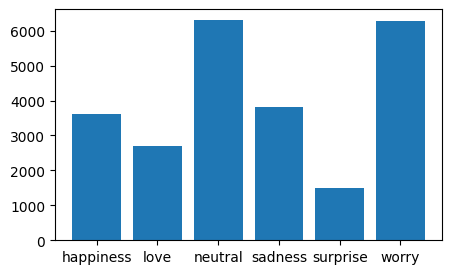

In [67]:
plt.figure(figsize=(5, 3))
plt.bar(counts.index, counts.values) # type: ignore

In [68]:
unique_classes = df["sentiment"].unique()
class_to_index = {x: i for i, x in enumerate(unique_classes)}
index_to_class = {i: x for i, x in enumerate(class_to_index.keys())}

In [69]:
print(class_to_index)
print(index_to_class)

{'sadness': 0, 'neutral': 1, 'worry': 2, 'surprise': 3, 'love': 4, 'happiness': 5}
{0: 'sadness', 1: 'neutral', 2: 'worry', 3: 'surprise', 4: 'love', 5: 'happiness'}


In [70]:
# word_embeddings.keys()

In [71]:
# word_list = [word for tweet in content for word in tweet]
# not_in_embeddings = [word for tweet in content for word in tweet if word not in word_embeddings]

# print(len(word_list))
# print(len(not_in_embeddings))
# w = [word for word in not_in_embeddings]
# print(w)

In [72]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import re

In [73]:
word_to_index = {word: index for index, word in enumerate(word_embeddings.keys())}

In [74]:
if '<UNK>' not in word_to_index:
    word_to_index['<UNK>'] = len(word_to_index)
if '<PAD>' not in word_to_index:
    word_to_index['<PAD>'] = 0

In [75]:
import keras
from keras.preprocessing.sequence import pad_sequences

In [76]:
df = df[pd.notnull(df['content'])]  # Removes rows where 'content' is NaN
df = df[df['content'].str.strip() != '']
lengths = df["content"].apply(len)

In [77]:
lengths.describe()

count    24133.000000
mean        59.561886
std         34.226037
min          1.000000
25%         32.000000
50%         53.000000
75%         84.000000
max        144.000000
Name: content, dtype: float64

In [78]:
def split_sentence(sentence):
    words = re.findall(r'\w+\'*\w|[^\w\s]', sentence)
    return [word for word in words if word]

In [79]:
df_split = df.copy()
df_split["content"] = df["content"].apply(
    lambda x: split_sentence(x))

In [80]:
df_split["content"].head()

0    [layin, bed, with, headache, ughh, ., ., waiti...
1      [funeral, ceremony, ., ., gloomy, friday, ., .]
2    [we, want, to, trade, with, someone, who, has,...
3                   [charlene, my, love, ., miss, you]
4            [am, sorry, at, least, it, is, friday, ?]
Name: content, dtype: object

In [81]:
df_split["lengths"] = df_split["content"].apply(len)
df_split = df_split[df_split["content"].apply(
    lambda x: bool(len(x) > 2))]

In [82]:
max_len_index = df_split["content"].apply(len).idxmax()

# Get the row with the maximum length
max_len_row = df_split.loc[max_len_index]
print(max_len_row["content"])
# Determine the maximum sequence length
max_len = df_split["content"].apply(len).max()
print(max_len)

['what', '!', '?', '!', '?', '!', 'ca', 'not', 'believe', 'had', 'to', 'find', 'out', 'this', 'way', '.', '.', 'do', 'not', 'you', 'ppl', 'contact', 'family', 'first', '?', '?', '!', '!', '?', 'am', 'so', 'sad', '!', 'who', 'was', 'it', '?', '!', '?']
39


In [83]:
df_split["content"] = df_split["content"].apply(
    lambda x: [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in x])

df_split["sentiment_one_hot"] = df_split["sentiment"].apply(
    lambda x: np.eye(len(class_to_index))[class_to_index[x]])

# Apply padding
df_split["content"] = pad_sequences(
    df_split["content"], maxlen=max_len, padding='post', value=word_to_index['<PAD>']).tolist()

In [84]:
class TextDataset(Dataset):
    def __init__(self, sentences, labels, lengths):
        self.sentences = sentences
        self.labels = labels
        self.lengths = lengths      
        print(len(self.sentences), len(self.labels), len(self.lengths))

    def __len__(self):
        return len(self.lengths)

    def __getitem__(self, idx):
        try:
            return torch.tensor(self.sentences[idx]), self.labels[idx], self.lengths[idx]
        except IndexError:
            print(f"Index {idx} out of range.")
            return None

In [85]:
df_split = df_split.reset_index(drop=True)

In [86]:
print(df_split["content"].shape)
print(df_split["sentiment_one_hot"].shape)
print(df_split["lengths"].shape)

(23344,)
(23344,)
(23344,)


In [87]:
texts = df_split["content"].tolist()
labels = df_split["sentiment_one_hot"].tolist()
lengths = df_split["lengths"].tolist()

assert len(texts) == len(labels) == len(lengths), "Input variables have inconsistent numbers of samples"

texts_train, texts_test, labels_train, labels_test, lengths_train, lengths_test = train_test_split(
    texts, labels, lengths, test_size=0.2)


train_dataset = TextDataset(texts_train, labels_train, lengths_train)
test_dataset = TextDataset(texts_test, labels_test, lengths_test)

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

18675 18675 18675
4669 4669 4669


In [88]:
labels[1:7]

[array([1., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0.])]

In [89]:
lengths[1:7]

[8, 16, 6, 8, 3, 4]

In [90]:
# data_iter = iter(train_loader)
# batch1 = next(data_iter)

In [91]:
vocab_size = len(word_to_index) + 1
embedding_dim = 50
embedding_matrix = torch.zeros([vocab_size, embedding_dim])

In [92]:
# Create embedding matrix
vocab_size = len(word_to_index) + 1
embedding_matrix = torch.zeros([vocab_size, embedding_dim])

for word, i in word_to_index.items():
    embedding_vector = word_embeddings.get(word)
    
    if embedding_vector is not None and embedding_vector.shape[0] == embedding_dim:
        embedding_matrix[i] = torch.tensor(embedding_vector)

In [93]:
import torch.nn.utils.rnn as rnn_utils

class TextClassificationModel(nn.Module):
    def __init__(self, embedding_dim, embedding_matrix, hidden_dim=128, num_classes=6, bidirectional=False, dropout_rate=0.5):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(
            hidden_dim * 2 if bidirectional else hidden_dim, num_classes)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = rnn_utils.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False)
        x, (h_n, c_n) = self.lstm(x)
        x, _ = rnn_utils.pad_packed_sequence(x, batch_first=True)

        x, _ = torch.max(x, dim=1)

        x = self.dropout(x)
        x = self.fc(x)
        return x

In [94]:
import matplotlib.pyplot as plt
device = torch.device('cpu')

In [95]:
def train_model(model, criterion, optimizer, train_loader):
    model.train()
    model.to(device)
    criterion.to(device)

    train_losses = []
    running_loss = 0.0
    running_corrects = 0
    total = 0
    
    for i, (inputs, labels, lengths) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == torch.argmax(labels.data, dim=1))
        total += labels.size(0)
        
        if i % 100 == 99:
            avg_loss = running_loss / total  # Average over total examples
            avg_acc = running_corrects.double() / total
            print(f"Batch: {i + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")
            train_losses.append(avg_loss)
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
    return model, train_losses

In [96]:
def evaluate_model(model, criterion, test_loader):
    model.eval()
    model.to(device)
    criterion.to(device)

    running_loss = 0.0
    corrects = 0
    total = 0
    test_losses = []

    with torch.no_grad():
        for i, (inputs, labels, lengths) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += torch.sum(preds == torch.argmax(labels.data, dim=1))
            running_loss += loss.item()

            if i % 100 == 99:
                avg_loss = running_loss / total  # Average over total examples
                avg_acc = corrects.double() / total
                print(f"Batch: {i + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")
                test_losses.append(avg_loss)
                running_loss = 0.0
                corrects = 0
                total = 0
                
    return test_losses

In [97]:
def model_fit(model, criterion, optimizer, train_loader, test_loader, num_epochs=25):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        model, train_loss = train_model(model, criterion, optimizer, train_loader)
        test_loss = evaluate_model(model, criterion, test_loader)
        train_losses.extend(train_loss)
        test_losses.extend(test_loss)

    return model, train_losses, test_losses

In [98]:
model = TextClassificationModel(embedding_dim, embedding_matrix, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

model, train_losses, test_losses = model_fit(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=3)

Epoch 1
Batch: 100, Loss: 0.052751762532279825, Accuracy: 0.28875
Batch: 200, Loss: 0.04950877458555624, Accuracy: 0.346875
Batch: 300, Loss: 0.04816041393991327, Accuracy: 0.3684375
Batch: 400, Loss: 0.047570834421203474, Accuracy: 0.3825
Batch: 500, Loss: 0.04721844255225733, Accuracy: 0.3840625
Batch: 100, Loss: 0.04683752971759532, Accuracy: 0.40125
Epoch 2
Batch: 100, Loss: 0.046114791757718196, Accuracy: 0.396875
Batch: 200, Loss: 0.0462902143606334, Accuracy: 0.405
Batch: 300, Loss: 0.04541532097835443, Accuracy: 0.4196875
Batch: 400, Loss: 0.0453716306862043, Accuracy: 0.4096875
Batch: 500, Loss: 0.04601250447783969, Accuracy: 0.4015625
Batch: 100, Loss: 0.045360954362840857, Accuracy: 0.4296875
Epoch 3
Batch: 100, Loss: 0.04385551865503658, Accuracy: 0.428125
Batch: 200, Loss: 0.045716389016379255, Accuracy: 0.414375
Batch: 300, Loss: 0.04465206111679436, Accuracy: 0.418125
Batch: 400, Loss: 0.04473276980221272, Accuracy: 0.4284375
Batch: 500, Loss: 0.044469810883456376, Accur

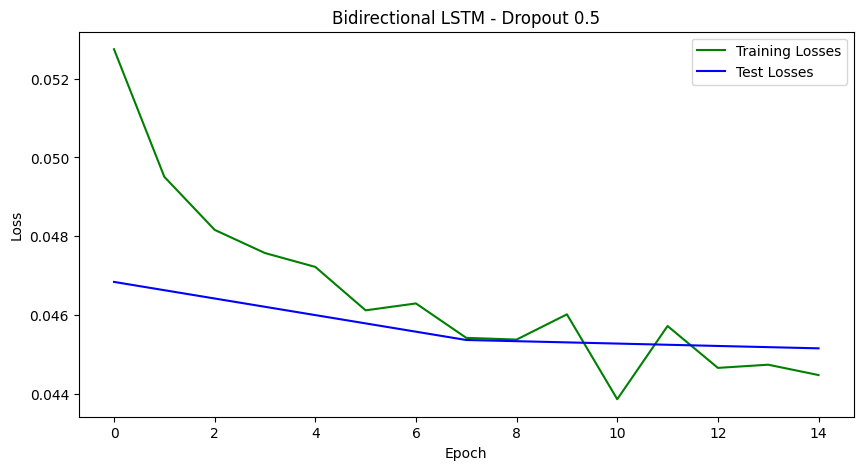

In [99]:
plt.figure(figsize=(10, 5))
train_epochs = range(len(train_losses))
test_epochs = np.linspace(0, len(train_losses)-1, num=len(test_losses))

plt.plot(train_epochs, train_losses, 'g-', label='Training Losses')
plt.plot(test_epochs, test_losses, 'b-', label='Test Losses')
plt.title('Bidirectional LSTM - Dropout 0.5')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [116]:
torch.save(model.state_dict(), 'model.pth')

Epoch 1
Batch: 100, Loss: 0.05228254242392723, Accuracy: 0.28875
Batch: 200, Loss: 0.04855049422068987, Accuracy: 0.3571875
Batch: 300, Loss: 0.047395174190460236, Accuracy: 0.3875
Batch: 400, Loss: 0.04707322679430945, Accuracy: 0.396875
Batch: 500, Loss: 0.04584222156190663, Accuracy: 0.398125
Batch: 100, Loss: 0.045711128115071914, Accuracy: 0.420625
Epoch 2
Batch: 100, Loss: 0.04534112736713723, Accuracy: 0.4128125
Batch: 200, Loss: 0.04481174786495103, Accuracy: 0.4253125
Batch: 300, Loss: 0.044603561108961, Accuracy: 0.430625
Batch: 400, Loss: 0.04457110906681919, Accuracy: 0.421875
Batch: 500, Loss: 0.04458783654583385, Accuracy: 0.4228125
Batch: 100, Loss: 0.045100219549203756, Accuracy: 0.4321875
Epoch 3
Batch: 100, Loss: 0.04367914108050172, Accuracy: 0.4425
Batch: 200, Loss: 0.043624108632138815, Accuracy: 0.4340625
Batch: 300, Loss: 0.04382779880143062, Accuracy: 0.438125
Batch: 400, Loss: 0.043413679518271235, Accuracy: 0.454375
Batch: 500, Loss: 0.043987331052339866, Accu

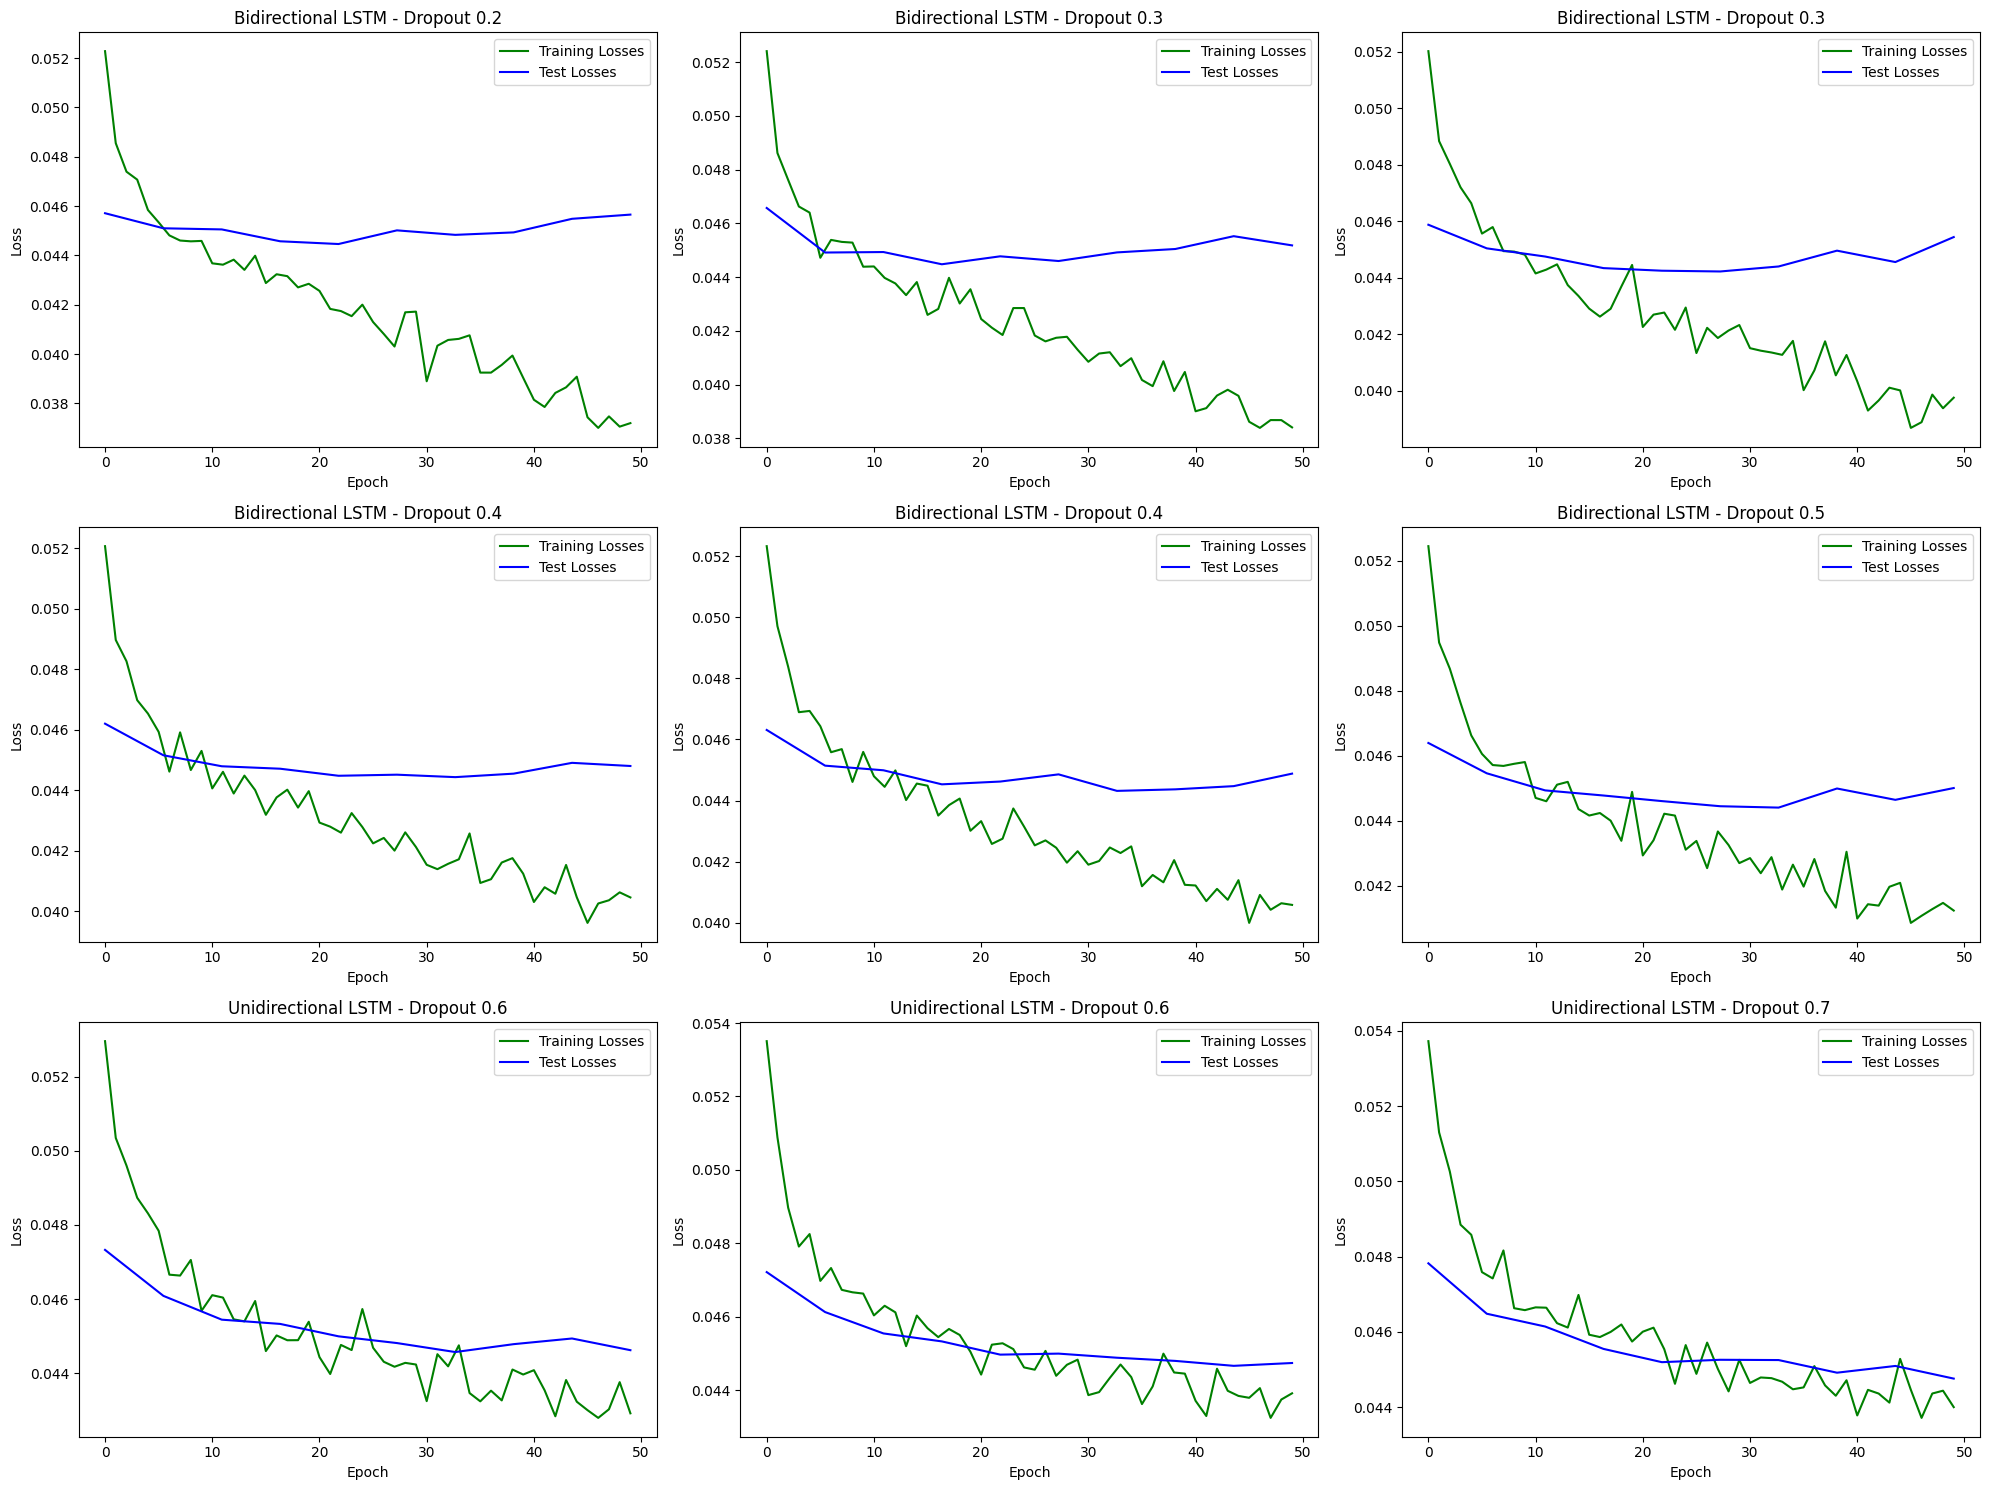

In [117]:
dropout_rates = np.linspace(0.2, 0.7, 9)
epochs = 10
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

for i, dropout_rate in enumerate(dropout_rates):
    bidirectional = True if i < 6 else False
    model = TextClassificationModel(
        embedding_dim, embedding_matrix, bidirectional=bidirectional, dropout_rate=dropout_rate)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model, train_losses, test_losses = model_fit(
        model, criterion, optimizer, train_loader, test_loader, num_epochs=epochs)

    train_epochs = range(len(train_losses))
    test_epochs = np.linspace(0, len(train_losses)-1, num=len(test_losses))

    axs[i//3, i % 3].plot(train_epochs, train_losses,
                          'g-', label='Training Losses')
    axs[i//3, i % 3].plot(test_epochs, test_losses, 'b-', label='Test Losses')
    axs[i//3, i % 3].set_title(
        f'{"Bidirectional" if bidirectional else "Unidirectional"} LSTM - Dropout {dropout_rate:.1f}')
    axs[i//3, i % 3].legend()
    axs[i//3, i % 3].set_xlabel('Epoch')
    axs[i//3, i % 3].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
dropout_rates = [0, 0.1, 0.2]
epochs = 10

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, dropout_rate in enumerate(dropout_rates):
    model = TextClassificationModel(
        embedding_dim, embedding_matrix, bidirectional=True, dropout_rate=dropout_rate)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model, train_losses, test_losses = model_fit(
        model, criterion, optimizer, train_loader, test_loader, num_epochs=epochs)

    train_epochs = range(len(train_losses))
    test_epochs = np.linspace(0, len(train_losses)-1, num=len(test_losses))

    axs[i].plot(train_epochs, train_losses, 'g-', label='Training Losses')
    axs[i].plot(test_epochs, test_losses, 'b-', label='Test Losses')
    axs[i].set_title(f'Bidirectional LSTM - Dropout {dropout_rate}')
    axs[i].legend()
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [102]:
def predict_tweet(tweet, model, split_sentence, word_to_index, index_to_class, max_len):

    inputs = split_sentence(tweet)
    lengths = len(inputs)
    
    inputs = [word_to_index[word]
              if word in word_to_index else word_to_index['<UNK>'] for word in inputs]

    # Apply padding
    inputs = pad_sequences([inputs], maxlen=max_len,
                           padding='post', value=word_to_index['<PAD>'])

    # Convert inputs to tensor
    inputs = torch.tensor(inputs)

    model.eval()
    with torch.no_grad():
        outputs = model(inputs, [lengths])

    # Get the predicted class
    _, predicted_class_index = torch.max(outputs, 1)

    # Convert the predicted class index to a class name
    predicted_class = index_to_class[predicted_class_index.item()]

    return predicted_class

In [124]:
# Load the model
# model = torch.load('model.pth')

# Make sure to put the model in evaluation mode
# model.eval()

# Now you can use the model to make predictions
tweet = "Your twwet to be entered here."
predicted_class = predict_tweet(tweet, model, split_sentence, word_to_index, index_to_class, max_len)
print(f"The predicted class for the tweet is: {predicted_class}")

The predicted class for the tweet is: neutral
